In [258]:
#import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pyEX as p
import math
from itertools import islice

In [259]:
#set up client
from sandboxToken import iexSandboxToken
c = p.Client(api_token=iexSandboxToken, version='sandbox')

In [269]:
#Import closing for TSLA
ticker = 'TLSA'
tempLoad = c.chart(symbol=ticker, timeframe='max')

my_columns = ['date', 'close']
tslaDf = pd.DataFrame(columns=my_columns)
tslaDf = tslaDf.append(tempLoad, ignore_index=True)
tslaDf = tslaDf[['date', 'close']]

print(tslaDf.head())

         date  close
0  2021-02-09   4.28
1  2021-02-08   4.28
2  2021-02-05   4.25
3  2021-02-04   4.13
4  2021-02-03   4.40


In [270]:
#add new columns for sma
#note, the below SMAs require a min value in the window as 1
#I could change the min_periods parameter to equal the window for a traditional moving average
tslaDf['20_SMA'] = tslaDf['close'].rolling(window=20, min_periods=20).mean()
tslaDf['50_SMA'] = tslaDf['close'].rolling(window=50, min_periods=50).mean()
tslaDf = tslaDf.sort_values(by='date', ascending=True)
#tslaDf = tslaDf.set_index('date')

print(tslaDf.head(20))

           date   close    20_SMA    50_SMA
514  2018-11-20  1.7100  1.723080  1.501090
513  2018-11-21  2.2200  1.718835  1.490290
512  2018-11-23  2.0300  1.682325  1.469170
511  2018-11-26  1.7316  1.655825  1.452570
510  2018-11-27  1.8280  1.643820  1.437938
509  2018-11-28  1.8650  1.619420  1.423778
508  2018-11-29  1.6359  1.601670  1.409078
507  2018-11-30  1.6000  1.592375  1.398160
506  2018-12-03  1.7130  1.582375  1.386160
505  2018-12-04  1.6900  1.564725  1.375620
504  2018-12-06  1.6590  1.550225  1.366700
503  2018-12-07  1.6000  1.537225  1.357520
502  2018-12-10  1.4630  1.526375  1.349200
501  2018-12-11  1.6119  1.521175  1.345140
500  2018-12-12  1.6900  1.513080  1.334902
499  2018-12-13  1.8146  1.493015  1.324282
498  2018-12-14  1.7000  1.458575  1.316004
497  2018-12-17  1.4796  1.433425  1.312804
496  2018-12-18  1.7200  1.428945  1.313214
495  2018-12-19  1.7000  1.412945  1.307794
515


In [271]:
#add a column for Signal
#boolean
#if 20 day SMA crosses (exceeds) 50 days SMA, thats a buy
#if 20 day SMA becomes less than 50 day SMA, thats a sell

tslaDf['Signal'] = 0.0
tslaDf['Signal'] = np.where(tslaDf['20_SMA'] > tslaDf['50_SMA'], 1.0, 0.0)

In [272]:
#add another column for position
#this will calculate the difference in signal value to determine if a buy or sell trigger occurs

tslaDf['Position'] = tslaDf['Signal'].diff()

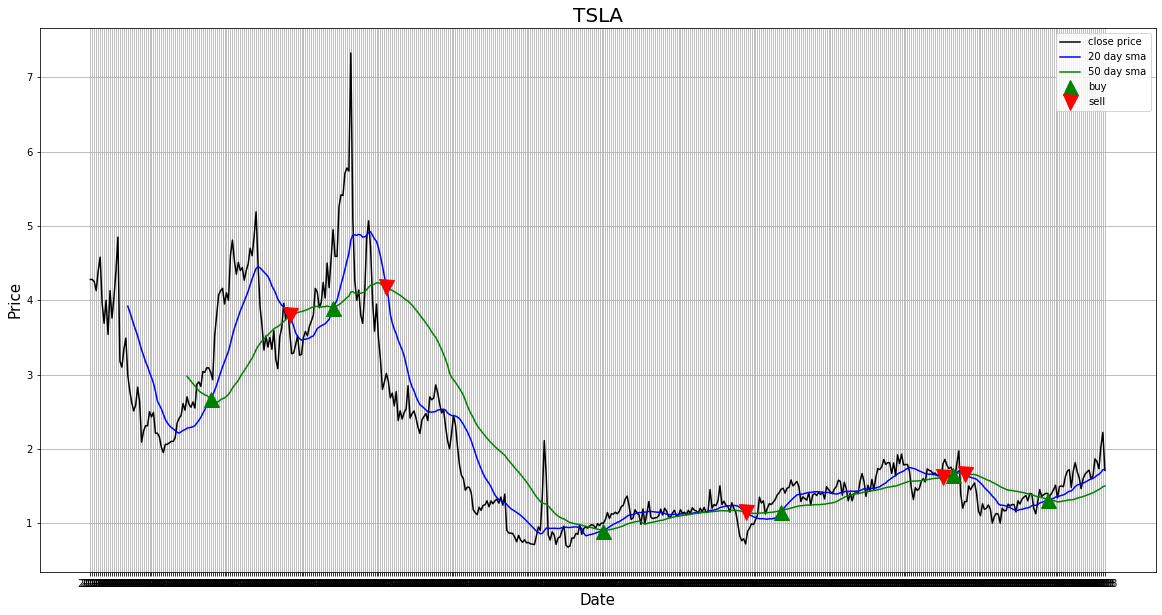

In [296]:
#plot
plt.figure(figsize=(20,10))
tslaDf['close'].plot(color='k', label='close price')
tslaDf['20_SMA'].plot(color='b', label='20 day sma')
tslaDf['50_SMA'].plot(color='g', label='50 day sma')

plt.plot()

#plot buy signals
plt.plot(tslaDf[tslaDf['Position'] == -1].index, 
         tslaDf['20_SMA'][tslaDf['Position'] == -1], 
         '^', markersize = 15, color = 'g', label = 'buy')

#plot sell signals
# plot ‘sell’ signals
plt.plot(tslaDf[tslaDf['Position'] == 1].index, 
         tslaDf['20_SMA'][tslaDf['Position'] == 1], 
         'v', markersize = 15, color = 'r', label = 'sell')

tslaDf['year'] = pd.DatetimeIndex(tslaDf['date']).year
plt.xticks(tslaDf.index, tslaDf['year'].values)

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('TSLA', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [275]:
dca = 1000
startDate = '2010-02-03'
endDate = '2021-02-01'

#tslaDf.to_csv(r'C:\Users\Parth\Documents\Python Scripts\Algo Trading\tslaPrices.csv')

def sharesToBuyOrSell(df=tslaDf):
    my_columns = ['Date', 'Type', 'Number of Shares Bought/Sold', 'Price', 'Total Shares', 'Net Change', 'Cost Basis', 'P/L', 'Market Value']
    bookDf = pd.DataFrame(columns=my_columns)
    #drop any values in the TSLA df that are outside the defined range
    df = df.loc[(df.date <= endDate) & (df.date >= startDate)]
    #tslaDf = tslaDf[tslaDf.date < endDate]
    #tslaDf = tslaDf[tslaDf.date > startDate]
    #df.to_csv(r'C:\Users\Parth\Documents\Python Scripts\Algo Trading\tslaPrices.csv')
    for index, row in df.iterrows():
        #print(row['Position'])
        if row['Position'] == 1:
            #print(row['date'])
            bookDf = bookDf.append(pd.Series([row['date'],
                                'Buy',
                                math.floor(dca/row['close']), 
                                row['close'], 0, 0, 0, 0, 0], index = my_columns), ignore_index=True)
        if row['Position'] == -1:
            #print(row['date'])
            bookDf = bookDf.append(pd.Series([row['date'],
                                'Sell',
                                math.floor(dca/row['close']), 
                                row['close'], 0, 0, 0, 0, 0], index = my_columns), ignore_index=True)
    
    if bookDf.loc[0, 'Type'] == 'Sell':
        bookDf.loc[0, 'Total Shares'] = 0
    else:
        bookDf.loc[0, 'Total Shares'] = bookDf.loc[0, 'Number of Shares Bought/Sold']
        bookDf.loc[0, 'Net Change'] = bookDf.loc[0, 'Price']*bookDf.loc[0, 'Number of Shares Bought/Sold']
    
    #for index, row in bookDf[:1].iterrows():
     #   if row['Type'] == 'Sell':
      #      if row['Total Shares'].shift() - row['Number of Shares Bought/Sold'] < 0:
       #         bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
        #        bookDf.loc[i, 'Total Shares'] = 0
         #       bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price'] 
        
    for i in range(1, len(bookDf['Date'])):        
        if bookDf.loc[i, 'Type'] == 'Sell':
            if bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold'] < 0:
                bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
                bookDf.loc[i, 'Total Shares'] = 0
                bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
            else:
                bookDf.loc[i, 'Total Shares'] = bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold']
                bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
            #if bookDf.loc[i-1, 'Total Shares'] - bookDf.loc[i, 'Number of Shares Bought/Sold'] < 0:
             #   bookDf.loc[i,'Number of Shares Bought/Sold'] = bookDf.loc[i-1, 'Total Shares']
              #  bookDf.loc[i, 'Total Shares'] = 0
              #  bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
        else:
            bookDf.loc[i, 'Total Shares'] = bookDf.loc[i, 'Number of Shares Bought/Sold'] + bookDf.loc[i-1, 'Total Shares']
            bookDf.loc[i, 'Net Change'] = bookDf.loc[i,'Number of Shares Bought/Sold']*bookDf.loc[i, 'Price']
        
    return bookDf

    #bookDf.to_csv(r'C:\Users\Parth\Documents\Python Scripts\Algo Trading\bookValues.csv')
    
sharesToBuyOrSell()
    
            

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,Cost Basis,P/L,Market Value
0,2019-01-08,Sell,714,1.4000,0,0,0,0,0
1,2019-04-11,Buy,775,1.2900,775,999.75,0,0,0
2,2019-04-30,Sell,588,1.7000,187,999.6,0,0,0
3,2019-05-07,Buy,556,1.7978,743,999.577,0,0,0
4,2019-09-16,Sell,686,1.4570,57,999.502,0,0,0
5,2019-10-10,Buy,1388,0.7200,1445,999.36,0,0,0
6,2020-01-29,Sell,1000,1.0000,445,1000,0,0,0
7,2020-07-07,Buy,331,3.0160,776,998.296,0,0,0
8,2020-08-13,Sell,202,4.9500,574,999.9,0,0,0
9,2020-09-15,Buy,279,3.5800,853,998.82,0,0,0


In [285]:
def totalShareTally():
    #define variable values at index 0
    bookDf = sharesToBuyOrSell()
    '''
    df = bookDf
    df['Adjusted Quantity'] = df.apply(lambda x: ((x['Number of Shares Bought/Sold'] > 0 - (x['Number of Shares Bought/Sold'] < 0)) * x['Quantity'], axis = 1)
    df['Adjusted Quantity'] = df['Adjusted Quantity'].cumsum()
    df['Adjusted Price Per Unit'] = df.apply(lambda x: ((x.Number of Shares Bought/Sold > 0) - (x.Number of Shares Bought/Sold < 0)) * x['Net Change'], axis = 1)
    df['Adjusted Price Per Unit'] = df['Adjusted Price Per Unit'].cumsum().div(df['Adjusted Quantity'])
    
    df.loc[df['Number of Shares Bought/Sold'] < 0,['Adjusted Price Per Unit']] = np.NaN
    df.fillna(method='ffill', inplace=True)
    return(df)
    '''
    
    
    df1 = (bookDf.copy()[bookDf['Type'] == 'Buy'].assign(CumAmountBuy = bookDf['Net Change'].cumsum()).assign(CumQtyBuy = bookDf['Number of Shares Bought/Sold'].cumsum()))
    df2 = pd.merge(bookDf, df1, how='left', on=['Date', 'Type', 'Number of Shares Bought/Sold', 'Price', 'Total Shares', 'Net Change', 'Cost Basis', 'P/L', 'Market Value']).ffill()
    #df2 = df2.fillna(0)
    s = df2['CumAmountBuy'] / df2['CumQtyBuy']
    s = s.fillna(0)
    df2['Average Cost'] = np.select([((df2['Type'] == 'Buy') & (df2['Type'].shift() == 'Sell')),
                         (df2['Type'] == 'Sell')],
                       [((df2['Number of Shares Bought/Sold'] * df2['Price'] + df2['Total Shares'].shift() * s.shift()) / df2['Total Shares']),
                        np.nan],
                       s)
    df2['Average Cost'] = round(df2['Average Cost'],3).ffill()
    #df2 = df2.drop(['Cost Basis', 'Market Value', 'CumQtyBuy', 'CumAmountBuy'], axis=1)
    #print(s)
    #return df1
    return df2

    
    
totalShareTally()
        
    

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,Cost Basis,P/L,Market Value,CumAmountBuy,CumQtyBuy,Average Cost
0,2019-01-08,Sell,714,1.4000,0,0.0000,0,0,0,NaN,NaN,NaN
1,2019-04-11,Buy,775,1.2900,775,999.7500,0,0,0,999.7500,1489.0,1.290
2,2019-04-30,Sell,588,1.7000,187,999.6000,0,0,0,999.7500,1489.0,1.290
3,2019-05-07,Buy,556,1.7978,743,999.5768,0,0,0,2998.9268,2633.0,1.514
4,2019-09-16,Sell,686,1.4570,57,999.5020,0,0,0,2998.9268,2633.0,1.514
5,2019-10-10,Buy,1388,0.7200,1445,999.3600,0,0,0,4997.7888,4707.0,0.737
6,2020-01-29,Sell,1000,1.0000,445,1000.0000,0,0,0,4997.7888,4707.0,0.737
7,2020-07-07,Buy,331,3.0160,776,998.2960,0,0,0,6996.0848,6038.0,1.895
8,2020-08-13,Sell,202,4.9500,574,999.9000,0,0,0,6996.0848,6038.0,1.895
9,2020-09-15,Buy,279,3.5800,853,998.8200,0,0,0,8994.8048,6519.0,1.951


In [291]:
'''
Average Cost might still be dubious but I'll move on...

Calculating P/L is just the difference between the previous row's average cost and the row price, multiplied
by the number of shares sold. It only applies to sold shares

Not gonna bother with market value
'''

def calcPL():
    df2 = totalShareTally()
    #skip the first column since sale cannot occur, no P/L
    for index, row in df2.iterrows():
        if row['Type'] == 'Sell':
            try:
                df2.loc[index, 'P/L'] = (row['Price']-df2.loc[index-1, 'Average Cost'])*row['Number of Shares Bought/Sold']
            except:
                pass
    return df2
calcPL()

,Date,Type,Number of Shares Bought/Sold,Price,Total Shares,Net Change,Cost Basis,P/L,Market Value,CumAmountBuy,CumQtyBuy,Average Cost
0,2019-01-08,Sell,714,1.4000,0,0.0000,0,0.000,0,NaN,NaN,NaN
1,2019-04-11,Buy,775,1.2900,775,999.7500,0,0.000,0,999.7500,1489.0,1.290
2,2019-04-30,Sell,588,1.7000,187,999.6000,0,241.080,0,999.7500,1489.0,1.290
3,2019-05-07,Buy,556,1.7978,743,999.5768,0,0.000,0,2998.9268,2633.0,1.514
4,2019-09-16,Sell,686,1.4570,57,999.5020,0,-39.102,0,2998.9268,2633.0,1.514
5,2019-10-10,Buy,1388,0.7200,1445,999.3600,0,0.000,0,4997.7888,4707.0,0.737
6,2020-01-29,Sell,1000,1.0000,445,1000.0000,0,263.000,0,4997.7888,4707.0,0.737
7,2020-07-07,Buy,331,3.0160,776,998.2960,0,0.000,0,6996.0848,6038.0,1.895
8,2020-08-13,Sell,202,4.9500,574,999.9000,0,617.110,0,6996.0848,6038.0,1.895
9,2020-09-15,Buy,279,3.5800,853,998.8200,0,0.000,0,8994.8048,6519.0,1.951
